<a href="https://colab.research.google.com/github/kode-git/ViT-emotion-recognition/blob/main/Data_Integration_on_ViT_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Transformers for Emotion Recognition


## 1. Introduction


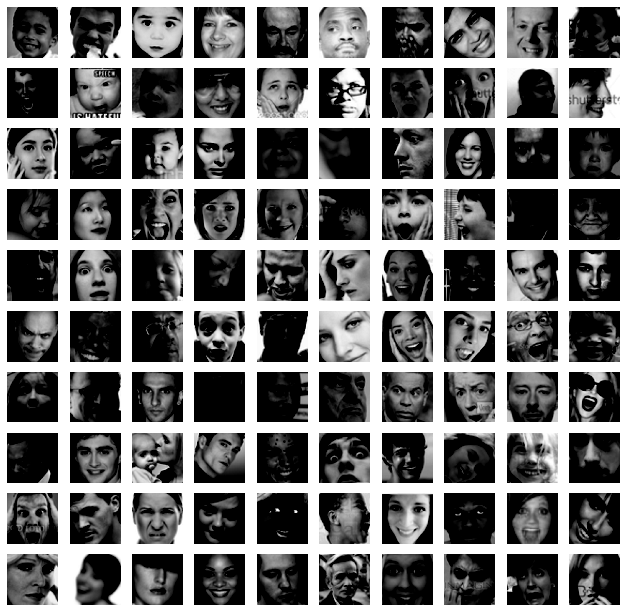

There are many datasets which can be useful for a visual classification of emotion. Our approach is based on the integration of the data management generally used to prepare samples on the training phase for a convolutional neural network but adapted for the transformers. In this case, we will focus on some integration based on 3 differents datasets: 

1.   AffectNet: We will use only some samples of this dataset because the entire version is not available for academic pourpose. It has 8 different classes of emotions with gray-scale and rgb-based images with different sizes.
2.   FER-2013: It is a classic dataset for the visual emotion recognition used for many training on convolutional configurations. It is formed by gray-scale images with 46x46 size. 
3. CK+: It is a dataset formed by some samples in gray-scale with 46x46 images.

We didn't know a priori if we will use the entire dataset given by the integration of the previous datasets. In any case, we integrate them in a ViT dataset. The data analysis and manipulation for the pre-processing phase will be done in another notebook. 

This notebook has the aim to load datasets informations on Google Drive and integrate them in one and omogeneous dataset formed by a classification of 8 different emotional classes.



## 2. Data Retrieval

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import keras
import os
import cv2
import glob
from google.colab import drive

Data sources about datasets described in the previous section are stored in Google Drive, so we need to manage file in a shared directory and integrate them in a single units with merging images of the same classes from different datasets.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The next snippet of code describes important functions used for the integration, ImageWorker is a class which we can use to convert the size format of an image (to make them in a standard dimension) and can evaluate the number of images per class in each of interested datasets.

In [ ]:

class ImageWorker():

    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_type, dest_path):
        """format_converter str

        Args:
            path (str): The source path of the images folder 
            format (str): Format of the images in the folder
            source_type (str): Type of the dataset 
            dest_path (str): Destination path to store resized images
        """        
        count = 0
        print("This is:", self.navigate_path(dest_path))

        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
            print('Resized writing for', dest_path + "resized_on_" + source_type + "_" + str(count) + "." + format_img )
            cv2.imwrite(dest_path + "resized_on_" + source_type + "_" + str(count) + "."+ format_img, resized)
            count += 1

    def navigate_path(self, path):
        """navigate_path

        Args:
            path (str): Path to navigate and counting number of files

        Returns:
            int : the total amount of file in the directory specified by the path
        """        
        count = 0
        for dir in os.listdir(path):
            if os.path.isfile(os.path.join(path, dir)):
                count += 1
        return count

iw = ImageWorker()

### 2.1 FER2013 Dataset
FER2013 is a dataset composed by 20.000 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class missed on this kind of dataset.

Loading data from the Google Drive

In [ ]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32

data_dir_fer= '/content/drive/My Drive/Datasets/FER-2013/'

FER2013 don't have so many samples for the disgust class. This observation guarantee a good motivation to merge it with other dataset and, also, for data augmentation phase.

In [ ]:
surprise_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/surprise/*.jpg")]
sad_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/sad/*.jpg")]
neutral_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/neutral/*.jpg")]
happy_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/My Drive/Datasets/FER-2013/train/happy/*.jpg")]
angry_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/angry/*.jpg")]
disgust_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/disgust/*.jpg")]

In [ ]:
fear_fer = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/train/fear/*.jpg")]

In [ ]:
print("Total no. of training images: ", len(fear_fer) +len(surprise_fer)+ len(sad_fer)+ len(neutral_fer)+ len(happy_fer)+len(angry_fer))

Total no. of training images:  28339


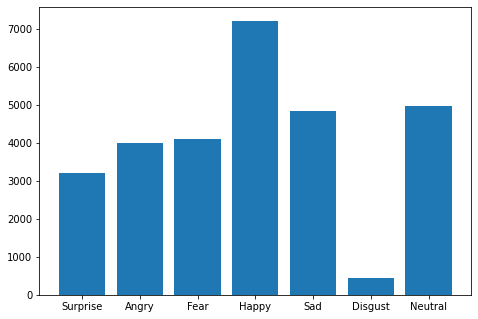

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral']
x = [len(surprise_fer), len(angry_fer), len(fear_fer), len(happy_fer), len(sad_fer), len(disgust_fer), len(neutral_fer)]
ax.bar(langs, x)
plt.show()

This dataset is pretty unbalanced for the disgust class, so we needs to manage it in data augmentation or data integration with some samples from other datasets to make a result set which have the same number of samples for each class.

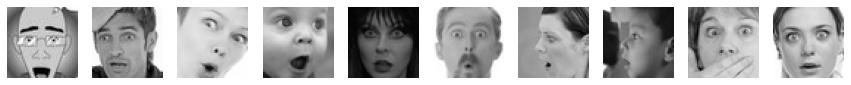

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_fer[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

This dataset is pretty good in terms of data views, with some variance on the patterns given by a great variability of facial expression for each category

Actually the image size is 48x48, we need to resize in 256x256 size and put together in the same folder of the other datasets for data integration. We will use our ImageWorker object to do that.

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/FER-2013/train/angry/"

# Neutral class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/FER-2013/train/neutral/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/FER-2013/train/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/FER-2013/train/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/FER-2013/train/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/FER-2013/train/sad/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/FER-2013/train/surprise/"

# Format of the image in the CK+
format = "jpg"

# Source type
source_type = "fer_2013"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_neutral, format,source_type, destination_path_neutral)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3047.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3048.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3049.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3050.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3051.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3052.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3053.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3054.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3055.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_fer_2013_3056.jpg
Resized writing for

The data integration phase didn't have any distinction between train and test splitting. So, we can merge the FER-2013 testing set with the training set and split it in a second time. Actually, our interest is to analyze the testing set as well as we did with the training set.

Total no. of training images:  7067


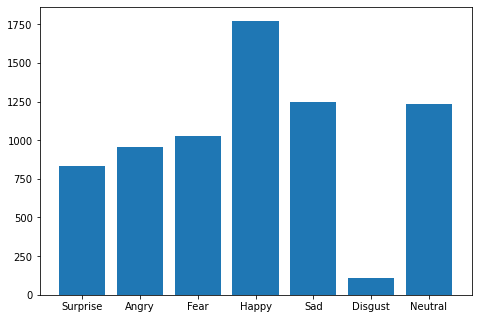

In [ ]:
surprise_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/surprise/*.jpg")]
sad_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/sad/*.jpg")]
neutral_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/neutral/*.jpg")]
happy_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/My Drive/Datasets/FER-2013/test/happy/*.jpg")]
angry_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/angry/*.jpg")]
disgust_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/disgust/*.jpg")]
fear_fer_2 = [cv2.imread(file) for file in glob.glob(r"/content/drive/MyDrive/Datasets/FER-2013/test/fear/*.jpg")]

print("Total no. of training images: ", len(fear_fer_2) +len(surprise_fer_2)+ len(sad_fer_2)+ len(neutral_fer_2)+ len(happy_fer_2)+len(angry_fer_2))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral']
x = [len(surprise_fer_2), len(angry_fer_2), len(fear_fer_2), len(happy_fer_2), len(sad_fer_2), len(disgust_fer_2), len(neutral_fer_2)]
ax.bar(langs, x)
plt.show()

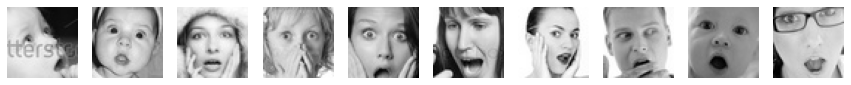

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_fer_2[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/FER-2013/test/angry/"

# Neutral class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/FER-2013/test/neutral/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/FER-2013/test/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/FER-2013/test/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/FER-2013/test/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/FER-2013/test/sad/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/FER-2013/test/surprise/"

# Format of the image in the CK+
format = "jpg"

# Source type
source_type = "fer_2013_test"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_neutral, format,source_type, destination_path_neutral)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1225.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1226.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1227.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1228.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1229.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1230.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1231.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/neutral/resized_on_fer_2013_test_1232.jpg
This is: 613
Resized writing for /content/drive/MyDrive/Datasets/ViT/disgust/resized_on_fer_2013_test_0.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/d

### 2.2  CK+ Dataset
A small dataset composed by 981 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [ ]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32

data_dir_ck = '/content/drive/My Drive/Datasets/CK+48'

In [ ]:
surprise_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/surprise/*.png')]
anger_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/anger/*.png')]
contempt_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/contempt/*.png')]
fear_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/fear/*.png')]
happy_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/happy/*.png')]
sad_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/sadness/*.png')]
disgust_ck = [cv2.imread(file) for file in glob.glob(r'/content/drive/MyDrive/Datasets/CK+48/disgust/*.png')]

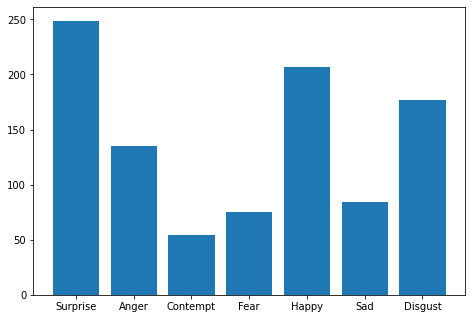

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Surprise', 'Anger', 'Contempt', 'Fear', 'Happy', 'Sad', 'Disgust']
x = [len(surprise_ck), len(anger_ck), len(contempt_ck), len(fear_ck), len(happy_ck), len(sad_ck), len(disgust_ck)]
ax.bar(langs, x)
plt.show()

In [ ]:
print('Total size of the CK+ dataset: ', len(surprise_ck) + len(anger_ck) + len(contempt_ck) + len(fear_ck) + len(happy_ck) + len(sad_ck) + len(disgust_ck))

Total size of the CK+ dataset:  981


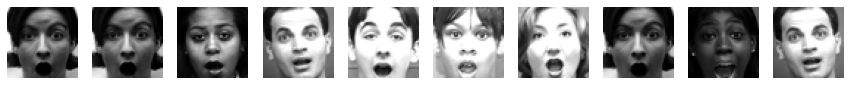

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(0,10):
  ax[i].imshow(cv2.cvtColor(surprise_ck[i], cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

Actually, the image size is 48x48, to retrieve some data in a common format, we will try to resize them mantaining pixels patterns for data processing. The new size is 256x256 that should mantain in a good way features of the samples. We will save the resized images in a new folder on the drive.

In [ ]:
!mkdir /content/drive/MyDrive/Datasets/ViT/contempt

In [ ]:
# Anger class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/CK+48/anger/"

# Contempt class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/CK+48/contempt/"

# Disgust class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/CK+48/disgust/"

# Fear class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/CK+48/fear/"

# Happy class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/CK+48/happy/"

# Sad class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/CK+48/sadness/"

# Surprise class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/CK+48/surprise/"

# Format of the image in the CK+
format = "png"

# Source type
source_type = "ck_plus"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_disgust, format,source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format,source_type, destination_path_fear)
iw.format_converter(source_path_happy, format,source_type, destination_path_happy)
iw.format_converter(source_path_sadness, format,source_type, destination_path_sadness)
iw.format_converter(source_path_surprise, format,source_type, destination_path_surprise)

This is: 4140
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_0.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_1.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_2.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_3.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_4.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_5.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_6.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_7.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_8.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_9.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_ck_plus_10.png
Resized writing for /content

In [ ]:
iw.format_converter(source_path_contempt, format,source_type, destination_path_contempt)

This is: 0
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_0.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_1.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_2.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_3.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_4.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_5.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_6.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_7.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_8.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_9.png
Resized writing for /content/drive/MyDrive/Datasets/ViT/contempt/resized_on_ck_plus_10.pn

At the end of data integration between FER-2013 and CK+48 sets, we got the following amount of total samples described in the following snippet of code

In [ ]:
def plot_ViT():
  angry_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/anger")
  contempt_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/contempt")
  disgust_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/disgust")
  fear_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/fear")
  happy_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/happy")
  neutral_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/neutral")
  sad_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/sadness")
  surprise_l = iw.navigate_path("/content/drive/MyDrive/Datasets/ViT/surprise")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral', 'Contempt']
  x = [surprise_l, angry_l, fear_l, happy_l, sad_l, disgust_l, neutral_l, contempt_l]
  ax.bar(langs, x)
  plt.show()
  print('\nTotal amount of samples: ', surprise_l + angry_l + fear_l + happy_l + sad_l + disgust_l + neutral_l + contempt_l)

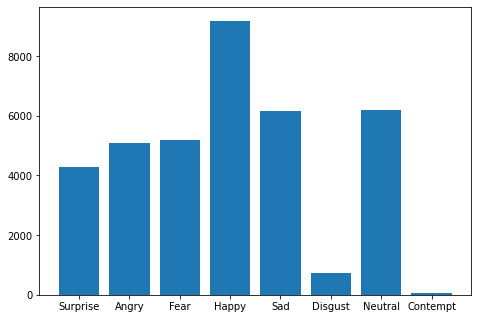


Total amount of samples:  36934


In [ ]:
plot_ViT()

### 2.3 AffectNet Dataset
AffectNet dataset is formed by some samples in different sizes, high-quality images in gray-scale or colored in RGB range. It has 8 different classes (surprise, angry, sad, contempt, disgust, fear, neutral, happy). As the FER-2013, there is a division between testing and training set, we will merge it as well as we did with FER subsets. Furthermore, we resize the different sizes of its images in 256x256 to estabilish the same amount of pixels for each sample.

In [ ]:
def plot_AffectNet(flag=""):
  dir = "train_class"
  if flag == "val":
    dir = "val_class"
  angry_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/anger")
  contempt_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/contempt")
  disgust_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/disgust")
  fear_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/fear")
  happy_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/happy")
  neutral_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/neutral")
  sad_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/sadness")
  surprise_l = iw.navigate_path("/content/drive/MyDrive/Datasets/AffectNet/" + dir + "/surprise")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = ['Surprise', 'Angry', 'Fear', 'Happy', 'Sad', 'Disgust', 'Neutral', 'Contempt']
  x = [surprise_l, angry_l, fear_l, happy_l, sad_l, disgust_l, neutral_l, contempt_l]
  ax.bar(langs, x)
  plt.show()
  print('\nTotal amount of samples: ', surprise_l + angry_l + fear_l + happy_l + sad_l + disgust_l + neutral_l + contempt_l)

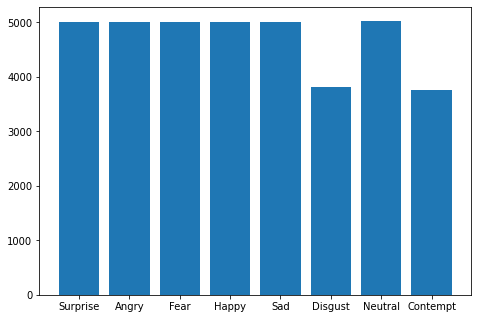


Total amount of samples:  37583


In [ ]:
plot_AffectNet()

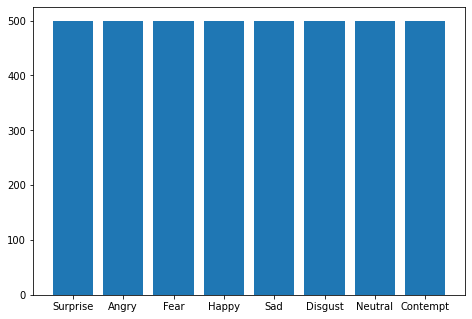


Total amount of samples:  4000


In [ ]:
plot_AffectNet("val")

In [ ]:
# Format of the image in the AffectNet
format = "jpg"


In [ ]:
# Surprise train subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/train_class/surprise/"

# Source type
source_type = "affectnet"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_surprise, format, source_type, destination_path_surprise)

# Surprise test subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/surprise/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/val_class/surprise/"

source_type = "affectnet_2"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_surprise, format, source_type, destination_path_surprise)

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_501.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_502.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_503.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_504.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_505.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_506.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_507.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_508.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_509.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/surprise/resized_on_affectnet_510.jpg
Resized w

In [ ]:
# Anger train subset class
destination_path_anger = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_anger = "/content/drive/MyDrive/Datasets/AffectNet/train_class/anger/"

# Contempt train subset class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/AffectNet/train_class/contempt/"

# Disgust train subset class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/AffectNet/train_class/disgust/"

# Fear train subset class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/AffectNet/train_class/fear/"

# Happy train subset class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/AffectNet/train_class/happy/"

# Neutral train subset class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/AffectNet/train_class/neutral/"

# Sadness train subset class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/AffectNet/train_class/sadness/"

# Source type
source_type = "affectnet"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_contempt, format, source_type, destination_path_contempt)
iw.format_converter(source_path_disgust, format, source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format, source_type, destination_path_fear)
iw.format_converter(source_path_happy, format, source_type, destination_path_happy)
iw.format_converter(source_path_neutral, format, source_type, destination_path_neutral)
iw.format_converter(source_path_sadness, format, source_type, destination_path_sadness)

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_0.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_1.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_2.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_3.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_4.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_5.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_6.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_7.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_8.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/sadness/resized_on_affectnet_9.jpg
Resized writing for /content/drive/MyDr

In [ ]:
# Anger test subset class
destination_path_surprise = "/content/drive/MyDrive/Datasets/ViT/anger/"
source_path_surprise = "/content/drive/MyDrive/Datasets/AffectNet/val_class/anger/"

# Contempt train subset class
destination_path_contempt = "/content/drive/MyDrive/Datasets/ViT/contempt/"
source_path_contempt = "/content/drive/MyDrive/Datasets/AffectNet/val_class/contempt/"

# Disgust train subset class
destination_path_disgust = "/content/drive/MyDrive/Datasets/ViT/disgust/"
source_path_disgust = "/content/drive/MyDrive/Datasets/AffectNet/val_class/disgust/"

# Fear train subset class
destination_path_fear = "/content/drive/MyDrive/Datasets/ViT/fear/"
source_path_fear = "/content/drive/MyDrive/Datasets/AffectNet/val_class/fear/"

# Happy train subset class
destination_path_happy = "/content/drive/MyDrive/Datasets/ViT/happy/"
source_path_happy = "/content/drive/MyDrive/Datasets/AffectNet/val_class/happy/"

# Neutral train subset class
destination_path_neutral = "/content/drive/MyDrive/Datasets/ViT/neutral/"
source_path_neutral = "/content/drive/MyDrive/Datasets/AffectNet/val_class/neutral/"

# Sadness train subset class
destination_path_sadness = "/content/drive/MyDrive/Datasets/ViT/sadness/"
source_path_sadness = "/content/drive/MyDrive/Datasets/AffectNet/val_class/sadness/"

source_type = "affectnet_2"

# Formatting and re-assemble for each class of the previous list
iw.format_converter(source_path_anger, format, source_type, destination_path_anger)
iw.format_converter(source_path_contempt, format, source_type, destination_path_contempt)
iw.format_converter(source_path_disgust, format, source_type, destination_path_disgust)
iw.format_converter(source_path_fear, format, source_type, destination_path_fear)
iw.format_converter(source_path_happy, format, source_type, destination_path_happy)
iw.format_converter(source_path_neutral, format, source_type, destination_path_neutral)
iw.format_converter(source_path_sadness, format, source_type, destination_path_sadness)

Streaming output truncated to the last 5000 lines.
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3006.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3007.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3008.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3009.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3010.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3011.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3012.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3013.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3014.jpg
Resized writing for /content/drive/MyDrive/Datasets/ViT/anger/resized_on_affectnet_2_3015.jpg
Resized w

### 2.4 ViT Dataset
ViT is the result datasets composed by the integration of images of the 3 different data sources described in the introduction section. It is formed by a mix of gray-scale and rgb-based images with same dimensions divided by subdirectories to divide different classes. We don't have any training/testing splitting yet.

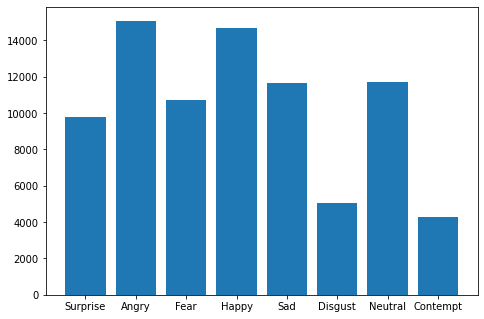


Total amount of samples:  83017


In [ ]:
plot_ViT()

Given the result dataset, we are ready to manage samples with procedures of data augmentation and pre-processing to prepare samples for the proposed models.